In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
#set the initial conditions of the bodies, intialize the velocities and positions
#to 0
bodies = [{"mass": 2e30, "R":0, "x":0, "y":0, "vx":0, "vy":0}, 
          {"mass": 6e26, "R":1e10, "x":0, "y":0, "vx":0, "vy":0},
          {"mass": 6e26, "R":2e10, "x":0, "y":0, "vx":0, "vy":0}]

G = 6.67e-11

In [31]:
#function that returns an array of the initial positions of the bodies
#assume initial y =0 and that we want the COM at the origin
def find_initial_positions(bodies):
    A = np.zeros((len(bodies), len(bodies)))
    Y = np.zeros((len(bodies), 1))

    masses = []
    for i in range(len(bodies)):
        masses.append(bodies[i]["mass"])
    A[0] = masses

    for i in range(1,len(bodies)):
        row = np.zeros(len(bodies))
        row[0] = -1
        row[i] = 1
        A[i] = row

    Y[0] = 0
    for i in range(1, len(bodies)):
        Y[i] = bodies[i]["R"]

    X = np.dot(np.linalg.inv(A), Y)
    return X.reshape(len(bodies))

In [32]:
X = find_initial_positions(bodies)
print(X)

#set the inital x positions, let the initial y positions be 0
for i in range(len(bodies)):
    bodies[i]["x"] = X[i]

[-8.99460324e+06  9.99100540e+09  1.99910054e+10]


In [33]:
#function that calulates omega of a two body orbit
def calc_omega(m1, m2, R):
    mu = (m1*m2) / (m1 + m2)
    omega = np.sqrt((G * m1 * m2) / (mu * R**3))
    return omega

In [34]:
#calculate omega of the planets
omega_list = []
for i in range(1, len(bodies)):
    omega = calc_omega(bodies[0]["mass"], bodies[i]["mass"], bodies[i]["R"])
    omega_list.append(omega)
    
print(omega_list)

[1.155162412823409e-05, 4.084115877396233e-06]


In [35]:
#set the initial y velocities, taking initial x velocities to be 0
bodies[0]["vy"] = np.mean(omega_list) * bodies[0]["x"]
for i in range(len(omega_list)):
    bodies[i+1]["vy"] = (omega_list[i] * bodies[i+1]["x"])

print(bodies[0]["vy"], bodies[1]["vy"])

-70.31863884203123 115412.33900655228


In [36]:
#function to find the distance between two points
def distance(x1,y1, x2, y2):
    return np.sqrt((x1 - x2)**2+(y1 - y2)**2)

In [37]:
#calculate the force on body1 from body2
#return the force in x and force in y
def calc_force(m1, x1, y1, m2, x2, y2):
    r =  distance(x1, y1, x2, y2)
    force_x = ((G*m1 * m2)/r**3)*(x2 - x1)
    force_y = ((G*m1 * m2)/r**3)*(y2 - y1)
    return force_x, force_y

In [38]:
#create the initial y vector
y0 = []
for body in bodies:
    y0.append(body["x"])
    y0.append(body["y"])
    y0.append(body["vx"])
    y0.append(body["vy"])
y0 = np.array(y0)
print(y0)

[-8.99460324e+06  0.00000000e+00  0.00000000e+00 -7.03186388e+01
  9.99100540e+09  0.00000000e+00  0.00000000e+00  1.15412339e+05
  1.99910054e+10  0.00000000e+00  0.00000000e+00  8.16455825e+04]


In [39]:
#function that calculates the time derivative of the y vector
def KeplerODE(y):
    r_list = []
    drdt_list = []
    for i in range(0, len(y), 4):
        r_list.append(y[i:i+2])
    for i in range(2, len(y), 4):
        drdt_list.append(y[i:i+2])

    dvdt_list = []
    for i in range(len(bodies)):
        f_x = 0
        f_y = 0
        for j in range(len(bodies)):
            if i != j:
                m1 = bodies[i]["mass"]
                m2 = bodies[j]["mass"]
                x1 = r_list[i][0]
                y1 = r_list[i][1]
                x2 = r_list[j][0]
                y2 = r_list[j][1]
                force_x, force_y = calc_force(m1, x1, y1, m2, x2, y2)
                f_x += force_x
                f_y += force_y
        dvdt_list.append([f_x / bodies[i]["mass"], f_y / bodies[i]["mass"]])
    dydt = []
    for i in range(len(drdt_list)):
        dydt.append(drdt_list[i])
        dydt.append(dvdt_list[i])

    return np.array(dydt).reshape(len(y0))

In [40]:
#function that estimates the period of an orbit
def find_period(body_index):
    ms = bodies[0]["mass"]
    mp = bodies[body_index]["mass"]
    R = bodies[body_index]["R"]

    P = np.sqrt((4*np.pi**2 / (G*(ms + mp)))*R**3)
    return P

In [41]:
#set the time-step to be 1000 of the faster orbit
dt = find_period(1) / 1000
print(dt)

543.9222430915526


In [42]:
#function that runs the orbit simulation and returns the x and y position
#and the radial velocity of the star
def run_simulation(y0, steps):
    x_pos = []
    y_pos = []
    vsr_list = []
    for body in bodies:
        x_pos.append([])
        y_pos.append([])
    y = np.copy(y0)
    for i in range(steps):
        vsr_list.append(y[3])
        for j in range(len(bodies)):
            x_pos[j].append(y[j*4])
            y_pos[j].append(y[j*4 + 1])
            bodies[j]["x"] = y[j*4]
            bodies[j]["y"] = y[j*4 + 1]
            bodies[j]["vx"] = y[j*4 + 2]
            bodies[j]["vy"] = y[j*4 + 3]


        F1 = KeplerODE(y)
        F2 = KeplerODE(y+((dt/2) * F1))
        F3 = KeplerODE(y+((dt/2) * F2))
        F4 = KeplerODE(y + (dt * F3))

        y = y + (dt / 6) * (F1 + 2*F2 + 2*F3 + F4)

    return x_pos, y_pos, vsr_list

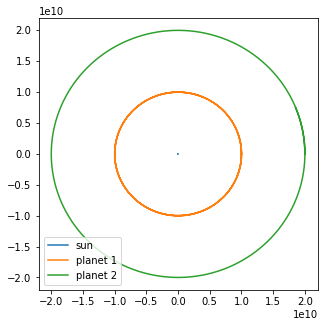

In [43]:
x, y, vsr = run_simulation(y0,3000)


plt.figure(figsize = (5,5))
plt.plot(x[0], y[0], label = 'sun')
plt.plot(x[1], y[1], label = 'planet 1')
plt.plot(x[2], y[2], label = 'planet 2')
plt.legend()
plt.show()

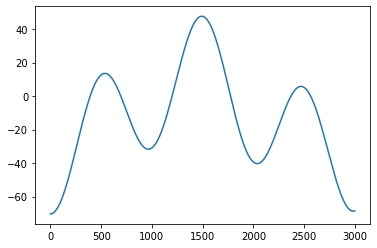

In [44]:
plt.plot(vsr)
plt.show()

In [45]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [47]:
#create our writer
Writer = animation.writers['ffmpeg']
writer = Writer(fps = 25, metadata = dict(artist = "Drechsler"), bitrate = 1800)

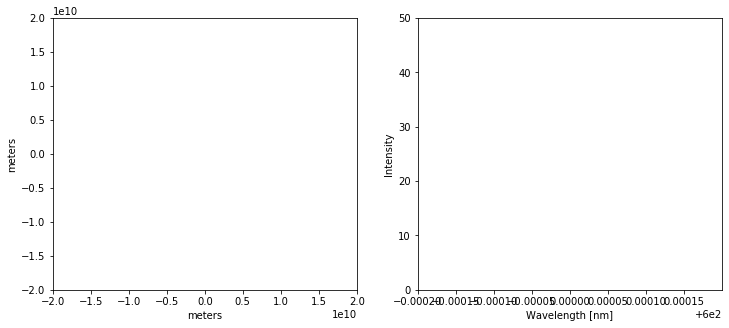

In [50]:
#initilize our axes and lines that we will animate
fig = plt.figure(1, figsize = (12,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_xlim(( -2e10, 2e10))
ax1.set_ylim((-2e10, 2e10))
ax1.set_xlabel("meters")
ax1.set_ylabel("meters")

ax2.set_xlim((599.9998, 600.0002))
ax2.set_ylim((0,50))
ax2.set_xlabel("Wavelength [nm]")
ax2.set_ylabel("Intensity")

line_s, = ax1.plot([], [], 'o', ms = 20)
line_p1, = ax1.plot([], [], 'o', ms = 10)
line_p2, = ax1.plot([], [], 'o', ms = 10)
line, = ax2.plot([],[])
plt.show()

In [51]:
#define gaussian
def gauss(x, A, mu, sigma):
    return A * np.exp((-1/2)*((x-mu)/sigma)**2)

599.9998593627223 600.0000952082103


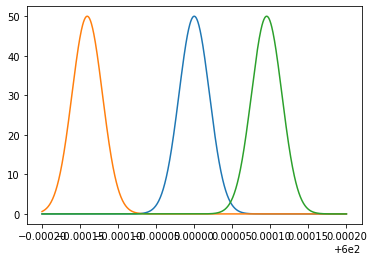

In [52]:
#find the new wavelengths at the min and max radial velocity
wvl0 = 600
c = 3e8
t = np.linspace(599.9998, 600.0002, 1000)
vmin = min(vsr)
vmax = max(vsr)

wvl1 = wvl0*((vmin / c) + 1)
wvl2 = wvl0*((vmax / c) + 1)

peak0 = gauss(t, 50, wvl0, 0.00002)
peak1 = gauss(t, 50, wvl1, 0.00002)
peak2 = gauss(t, 50, wvl2, 0.00002)

print(wvl1, wvl2)

plt.plot(t, peak0)
plt.plot(t, peak1)
plt.plot(t, peak2)

In [53]:
#find the peak of the spectrum for each timestep
peaks = []
for i in range(len(vsr)):
    wvl = wvl0 *((vsr[i] / c) + 1)
    peaks.append(wvl)

In [54]:
#create our init function
def init():
    line_s.set_data([], [])
    line_p1.set_data([], [])
    line_p2.set_data([], [])
    line.set_data([],[])
    return line_s, 
    return line_p1,
    return line_p2,
    return line

In [56]:
#function that plots the position and simulated spectrum feature every 
# 10 timesteps
def animate(i):
    xs = x[0][i*10]
    ys = y[0][i*10]
    x1 = x[1][i*10]
    y1 = y[1][i*10]
    x2 = x[2][i*10]
    y2 = y[2][i*10]
    line_s.set_data(xs, ys)
    line_p1.set_data(x1, y1)
    line_p2.set_data(x2, y2)

    x_spec = np.linspace(599.9998, 600.0002, 1000)
    y_spec = gauss(x_spec, 50, peaks[i*10], 0.00002)
    line.set_data(x_spec,y_spec)
    
    return (line_s,)
    return (line_p1,)
    return (line_p2,)
    return (line,)

In [57]:
#create the animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames = int(len(peaks) / 10), interval=20, blit=True)

In [130]:
#save the animation as an mp4
anim.save('animation.mp4', writer = writer)